<a href="https://colab.research.google.com/github/nug1209/PwC_Switzerland_Digital_Intelligence_Virtual_Case_Experience/blob/main/PwC_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I'm making classification model to predict whether a customer would subscribe to a term deposit. After that, I obtain global feature importances and several local feature importances. I'm goint to make random forest and XGBoost models with cross validation and hyperparameter tuning. The feature importances will be created from whichever model produces better performance.

Dataset source: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing

Project website at The Forage: https://www.theforage.com/virtual-internships/Kaib4AmLSAG5mDsD4?ref=eqQHWa4Z8GzfL48NJ

In [3]:
!pip install shap
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=c21df2b534cb5a6ee33e0d1ef4b8eb783c88fb98ffb49a7952f53dfd28b211e9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from google.colab import drive
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, LabelBinarizer, StandardScaler
import os
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import shap
import lime.lime_tabular
from sklearn_pandas import DataFrameMapper

Import data.

In [5]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Datasets/bank-additional-full.csv'
df = pd.read_csv(path, delimiter=';')
df_copy = df.copy()
df.head(3)

Mounted at /content/drive


age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  

[3 rows x 21 columns]

Check the data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Rename columns for convenience.

In [7]:
rename_columns = {'default':'has_default',
                  'housing':'has_housing_loan',
                  'loan':'has_personal_loan',
                  'contact':'contact_type',
                  'month':'last_contact_month',
                  'day_of_week':'last_contact_day_of_week',
                  'duration':'last_contact_duration',
                  'campaign':'number_of_contacts_in_current_campaign',
                  'pdays':'days_after_previous_campaign',
                  'previous':'number_of_contacts_before_current_campaign',
                  'poutcome':'previous_outcome',
                  'emp.var.rate':'employment_variation_rate',
                  'cons.price.idx':'consumer_price_index',
                  'cons.conf.idx':'consumer_confidence_index',
                  'euribor3m':'euribor_3_month',
                  'nr.employed':'number_of_employees',
                  'y':'term_deposit_subscription'}
df = df.rename(columns=rename_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         41188 non-null  int64  
 1   job                                         41188 non-null  object 
 2   marital                                     41188 non-null  object 
 3   education                                   41188 non-null  object 
 4   has_default                                 41188 non-null  object 
 5   has_housing_loan                            41188 non-null  object 
 6   has_personal_loan                           41188 non-null  object 
 7   contact_type                                41188 non-null  object 
 8   last_contact_month                          41188 non-null  object 
 9   last_contact_day_of_week                    41188 non-null  object 
 10  last_conta

Take a look at the data.

In [8]:
for i in df.select_dtypes(include='object').columns:
  print('Unique values in the categorical column', i)
  print(df[i].unique())
  print('')

Unique values in the categorical column job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in the categorical column marital
['married' 'single' 'divorced' 'unknown']

Unique values in the categorical column education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in the categorical column has_default
['no' 'unknown' 'yes']

Unique values in the categorical column has_housing_loan
['no' 'yes' 'unknown']

Unique values in the categorical column has_personal_loan
['no' 'yes' 'unknown']

Unique values in the categorical column contact_type
['telephone' 'cellular']

Unique values in the categorical column last_contact_month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in the categorical column last_contact_day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']

Unique val

In [9]:
df.describe()

age  last_contact_duration  \
count  41188.00000           41188.000000   
mean      40.02406             258.285010   
std       10.42125             259.279249   
min       17.00000               0.000000   
25%       32.00000             102.000000   
50%       38.00000             180.000000   
75%       47.00000             319.000000   
max       98.00000            4918.000000   

       number_of_contacts_in_current_campaign  days_after_previous_campaign  \
count                            41188.000000                  41188.000000   
mean                                 2.567593                    962.475454   
std                                  2.770014                    186.910907   
min                                  1.000000                      0.000000   
25%                                  1.000000                    999.000000   
50%                                  2.000000                    999.000000   
75%                                  3.000000                    999.000000   
max                                 56.000000                    999.000000   

       number_of_contacts_before_current_campaign  employment_variation_rate  \
count                                41188.000000               41188.000000   
mean                                     0.172963                   0.081886   
std                                      0.494901                   1.570960   
min                                      0.000000                  -3.400000   
25%                                      0.000000                  -1.800000   
50%                                      0.000000                   1.100000   
75%                                      0.000000                   1.400000   
max                                      7.000000                   1.400000   

       consumer_price_index  consumer_confidence_index  euribor_3_month  \
count          41188.000000               41188.000000     41188.000000   
mean              93.575664                 -40.502600         3.621291   
std                0.578840                   4.628198         1.734447   
min               92.201000                 -50.800000         0.634000   
25%               93.075000                 -42.700000         1.344000   
50%               93.749000                 -41.800000         4.857000   
75%               93.994000                 -36.400000         4.961000   
max               94.767000                 -26.900000         5.045000   

       number_of_employees  
count         41188.000000  
mean           5167.035911  
std              72.251528  
min            4963.600000  
25%            5099.100000  
50%            5191.000000  
75%            5228.100000  
max            5228.100000

Create new column about whether the customer were contacted in previous campaign.

In [10]:
df['contacted_in_previous_campaign'] = np.where(df['days_after_previous_campaign'] == 999, 0, 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         41188 non-null  int64  
 1   job                                         41188 non-null  object 
 2   marital                                     41188 non-null  object 
 3   education                                   41188 non-null  object 
 4   has_default                                 41188 non-null  object 
 5   has_housing_loan                            41188 non-null  object 
 6   has_personal_loan                           41188 non-null  object 
 7   contact_type                                41188 non-null  object 
 8   last_contact_month                          41188 non-null  object 
 9   last_contact_day_of_week                    41188 non-null  object 
 10  last_conta

In [11]:
df.sample(3)
# df['contacted_in_previous_campaign'].unique()

age         job  marital          education has_default  \
37657   37      admin.  married  university.degree          no   
7304    59  management  married           basic.4y     unknown   
8793    29    services   single        high.school          no   

      has_housing_loan has_personal_loan contact_type last_contact_month  \
37657               no               yes     cellular                aug   
7304               yes                no    telephone                may   
8793               yes                no    telephone                jun   

      last_contact_day_of_week  ...  days_after_previous_campaign  \
37657                      tue  ...                           999   
7304                       thu  ...                           999   
8793                       thu  ...                           999   

       number_of_contacts_before_current_campaign  previous_outcome  \
37657                                           1           failure   
7304                                            0       nonexistent   
8793                                            0       nonexistent   

       employment_variation_rate consumer_price_index  \
37657                       -2.9               92.201   
7304                         1.1               93.994   
8793                         1.4               94.465   

       consumer_confidence_index  euribor_3_month  number_of_employees  \
37657                      -31.4            0.859               5076.2   
7304                       -36.4            4.860               5191.0   
8793                       -41.8            4.866               5228.1   

       term_deposit_subscription  contacted_in_previous_campaign  
37657                         no                               0  
7304                          no                               0  
8793                          no                               0  

[3 rows x 22 columns]

Change the target column to numeric.

In [12]:
df['term_deposit_subscription'] = np.where(df['term_deposit_subscription'] == 'yes', 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         41188 non-null  int64  
 1   job                                         41188 non-null  object 
 2   marital                                     41188 non-null  object 
 3   education                                   41188 non-null  object 
 4   has_default                                 41188 non-null  object 
 5   has_housing_loan                            41188 non-null  object 
 6   has_personal_loan                           41188 non-null  object 
 7   contact_type                                41188 non-null  object 
 8   last_contact_month                          41188 non-null  object 
 9   last_contact_day_of_week                    41188 non-null  object 
 10  last_conta

Replace the 999 value in the column days_after_previous_campaign to the column's max value plus 7. Just to reduce the skewness.

In [13]:
# df.describe()

In [14]:
# Get the second larget number in column

second_largest = np.partition(df['days_after_previous_campaign'].unique(), -2)[-2]

df['days_after_previous_campaign'] = df['days_after_previous_campaign'].replace([999], second_largest + 7)
df.describe()

age  last_contact_duration  \
count  41188.00000           41188.000000   
mean      40.02406             258.285010   
std       10.42125             259.279249   
min       17.00000               0.000000   
25%       32.00000             102.000000   
50%       38.00000             180.000000   
75%       47.00000             319.000000   
max       98.00000            4918.000000   

       number_of_contacts_in_current_campaign  days_after_previous_campaign  \
count                            41188.000000                  41188.000000   
mean                                 2.567593                     32.970623   
std                                  2.770014                      5.318502   
min                                  1.000000                      0.000000   
25%                                  1.000000                     34.000000   
50%                                  2.000000                     34.000000   
75%                                  3.000000                     34.000000   
max                                 56.000000                     34.000000   

       number_of_contacts_before_current_campaign  employment_variation_rate  \
count                                41188.000000               41188.000000   
mean                                     0.172963                   0.081886   
std                                      0.494901                   1.570960   
min                                      0.000000                  -3.400000   
25%                                      0.000000                  -1.800000   
50%                                      0.000000                   1.100000   
75%                                      0.000000                   1.400000   
max                                      7.000000                   1.400000   

       consumer_price_index  consumer_confidence_index  euribor_3_month  \
count          41188.000000               41188.000000     41188.000000   
mean              93.575664                 -40.502600         3.621291   
std                0.578840                   4.628198         1.734447   
min               92.201000                 -50.800000         0.634000   
25%               93.075000                 -42.700000         1.344000   
50%               93.749000                 -41.800000         4.857000   
75%               93.994000                 -36.400000         4.961000   
max               94.767000                 -26.900000         5.045000   

       number_of_employees  term_deposit_subscription  \
count         41188.000000               41188.000000   
mean           5167.035911                   0.112654   
std              72.251528                   0.316173   
min            4963.600000                   0.000000   
25%            5099.100000                   0.000000   
50%            5191.000000                   0.000000   
75%            5228.100000                   0.000000   
max            5228.100000                   1.000000   

       contacted_in_previous_campaign  
count                    41188.000000  
mean                         0.036783  
std                          0.188230  
min                          0.000000  
25%                          0.000000  
50%                          0.000000  
75%                          0.000000  
max                          1.000000

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         41188 non-null  int64  
 1   job                                         41188 non-null  object 
 2   marital                                     41188 non-null  object 
 3   education                                   41188 non-null  object 
 4   has_default                                 41188 non-null  object 
 5   has_housing_loan                            41188 non-null  object 
 6   has_personal_loan                           41188 non-null  object 
 7   contact_type                                41188 non-null  object 
 8   last_contact_month                          41188 non-null  object 
 9   last_contact_day_of_week                    41188 non-null  object 
 10  last_conta

Visualize the numerical columns

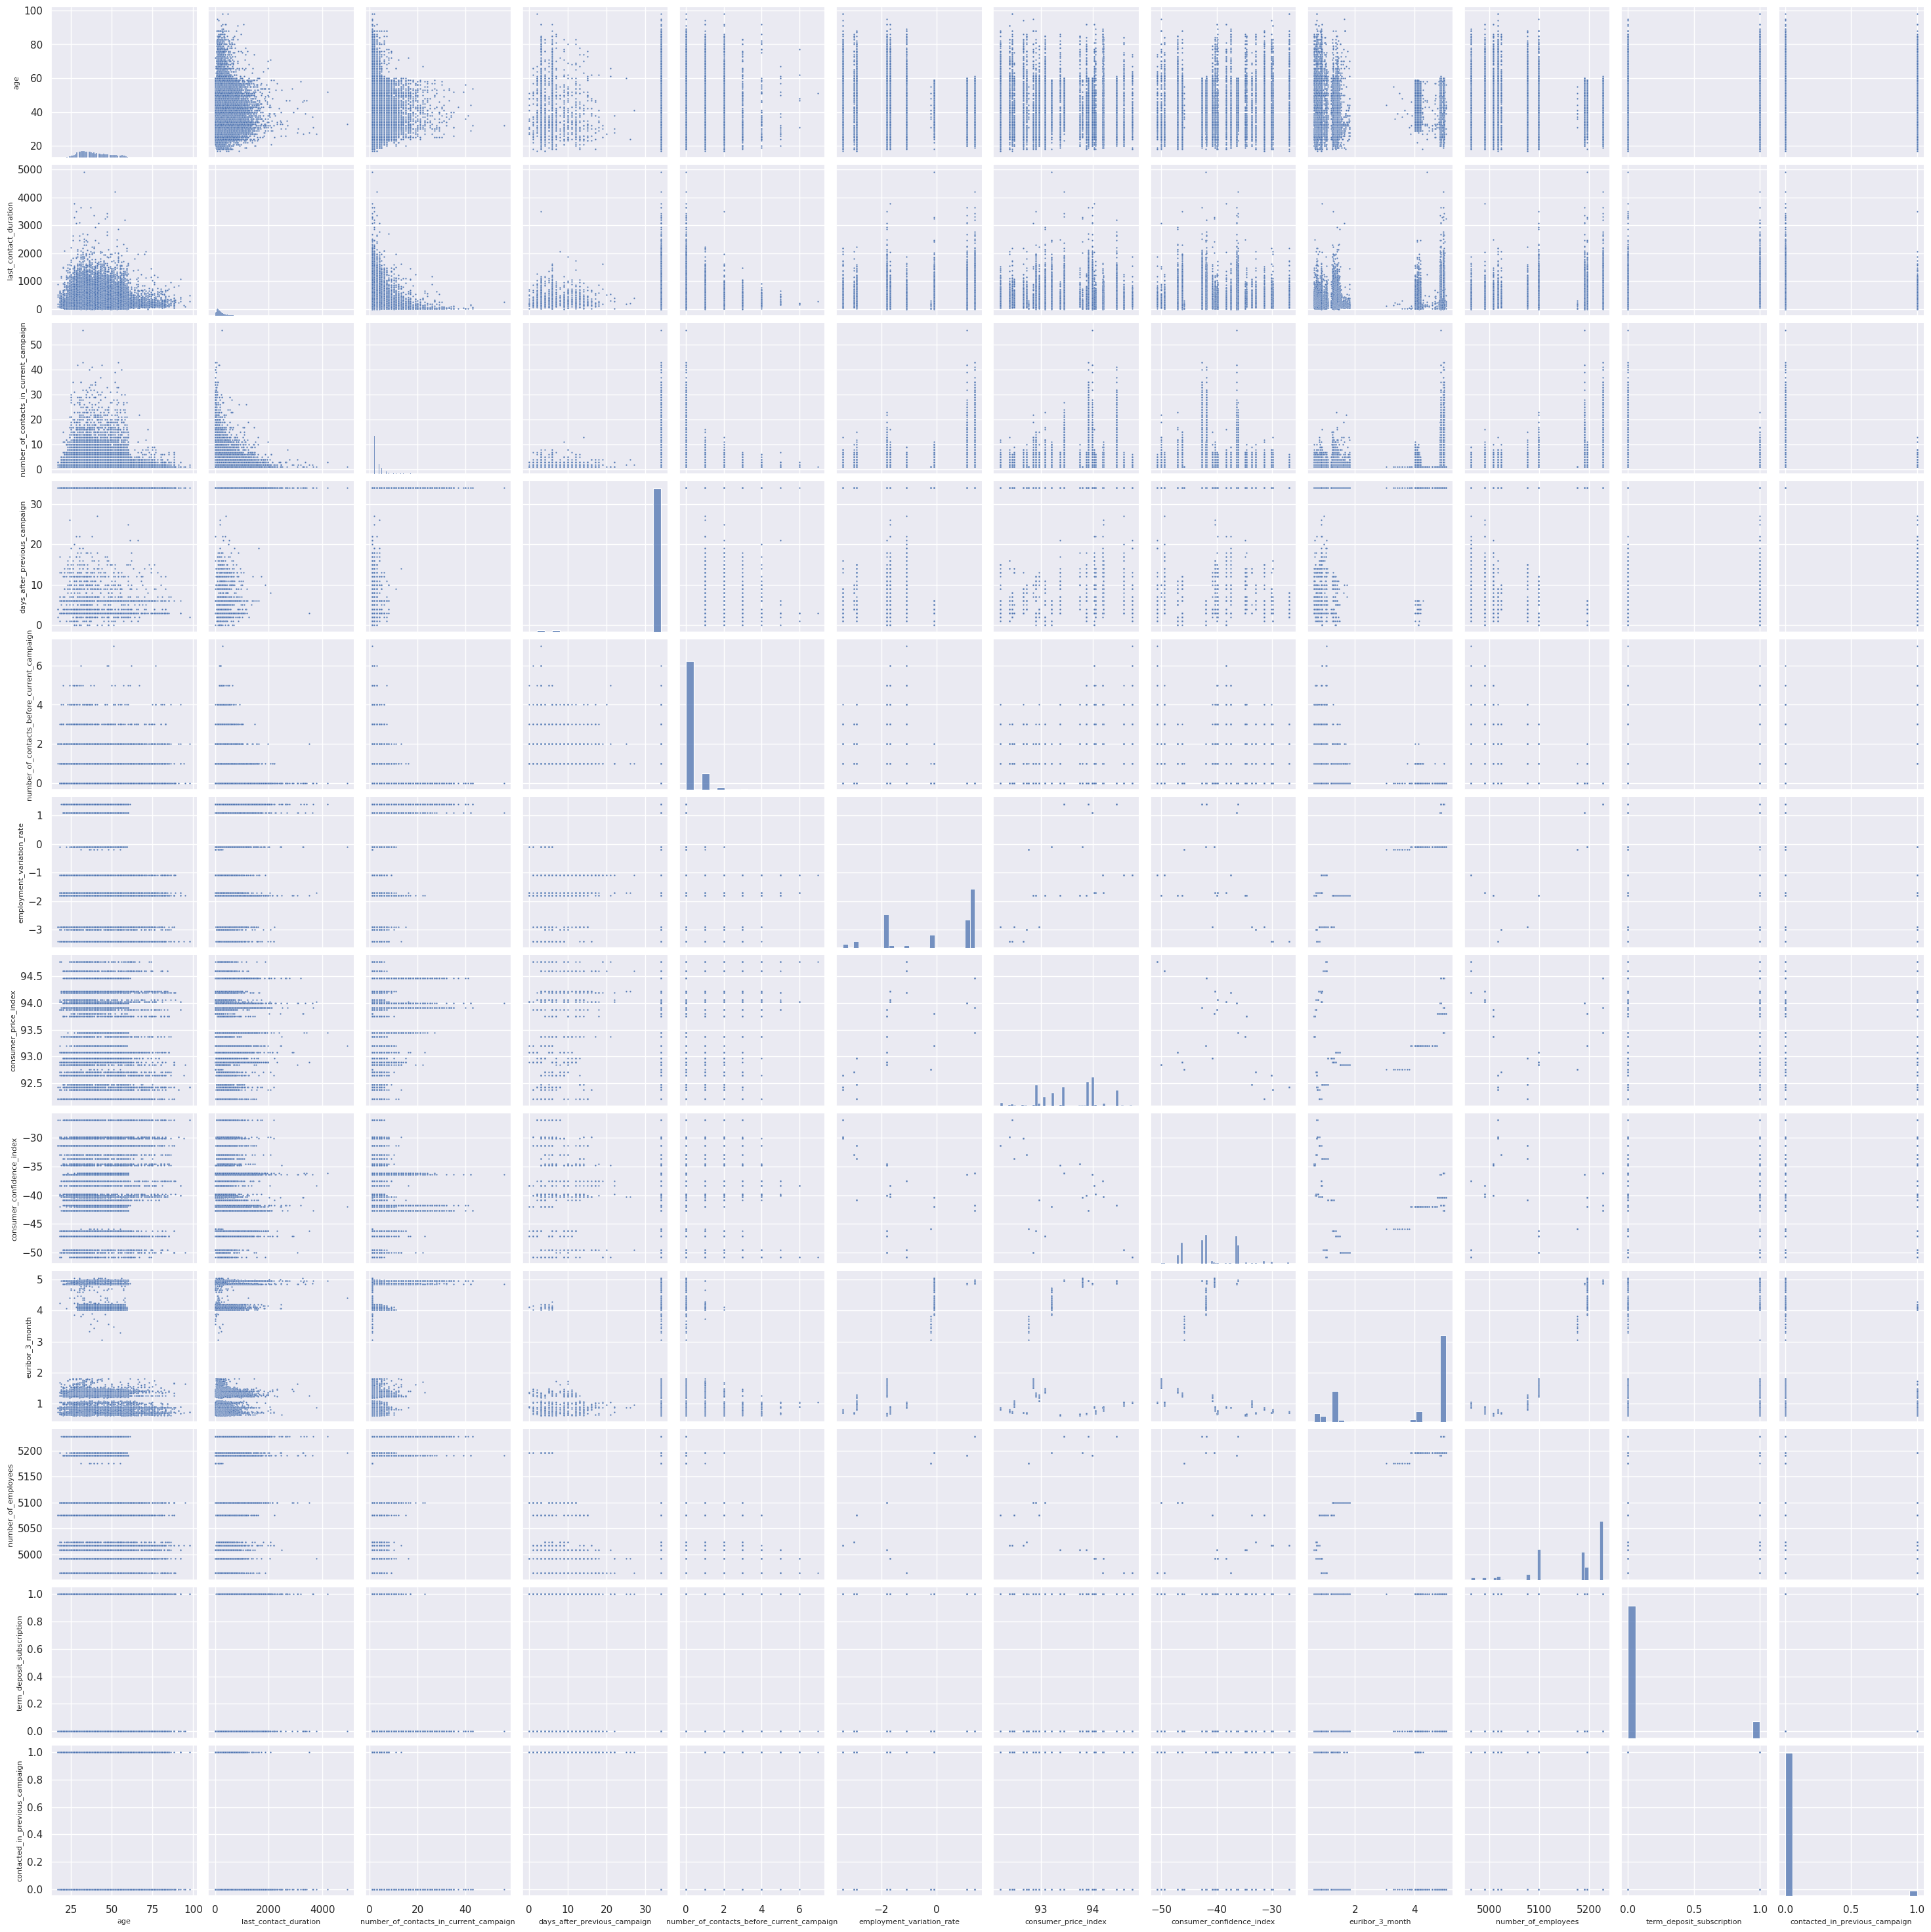

In [16]:
numerical_columns = list(df.select_dtypes('number').columns)



## Visualize the data without the hue, but I disable this code to save time. I load the prebuilt image instead.

# sns.set(rc={'figure.figsize':(60, 60), 'axes.labelsize': 8})
# sns.pairplot(df[numerical_columns], plot_kws={'s':3})

## Load the prebuilt image.
image_path = '/content/drive/MyDrive/Virtual Experience/pwc_1_numerical_viz.png'
Image(image_path)


## This code is not working. I don't know why.

# if os.path.isfile(image_path)==True:
#   Image(image_path)
# else:
#   numerical_columns = list(df.select_dtypes('number').columns)
#   sns.set(rc={'figure.figsize':(60, 60), 'axes.labelsize': 8})
#   sns.pairplot(df[numerical_columns], hue='term_deposit_subscription', plot_kws={'s':3})



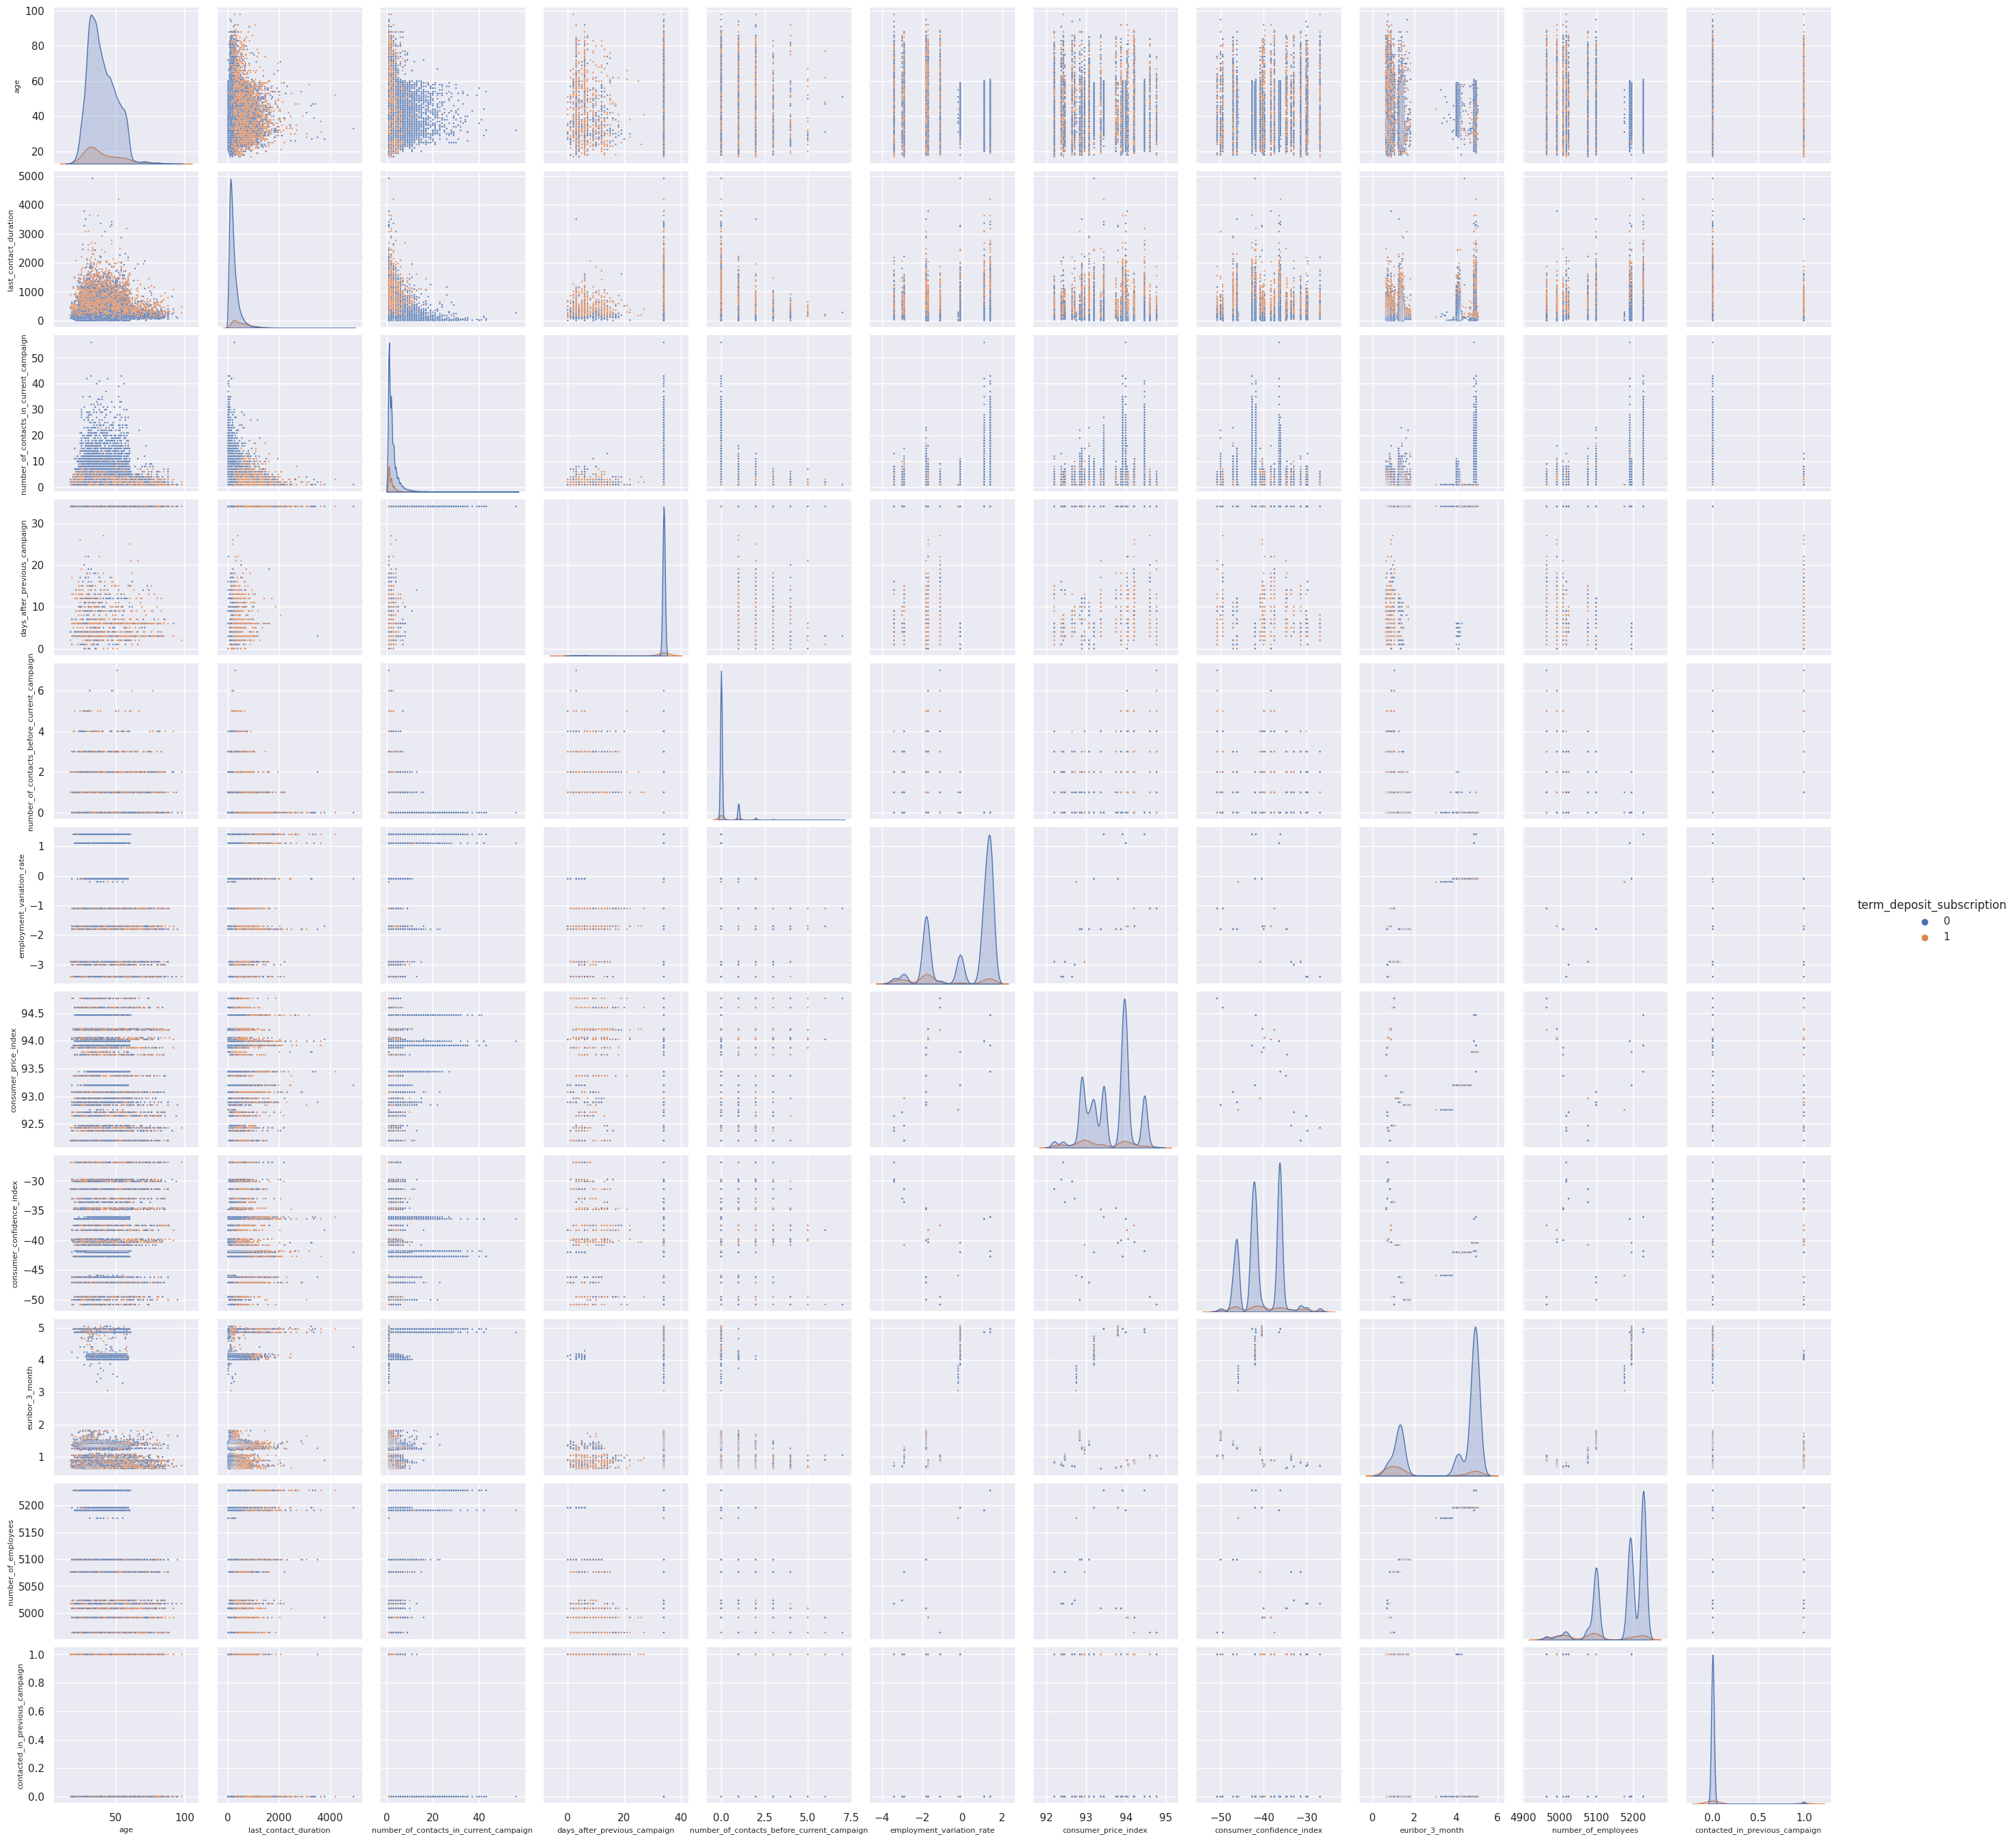

In [17]:
## Visualize the data with the hue, but I disable this code to save time. I load the prebuilt image instead.

# sns.set(rc={'figure.figsize':(60, 60), 'axes.labelsize': 8})
# sns.pairplot(df[numerical_columns], hue='term_deposit_subscription', plot_kws={'s':3})

## Load the prebuilt image.

image_path_hue = '/content/drive/MyDrive/Virtual Experience/pwc_1_numerical_viz_hue.png'
Image(image_path_hue)

 I'm not going to get into detailed observation of the visualizations. There are possibly interesting insights to find there, but I intend to continue fast forward to modeling.

Visualize the categorical columns.

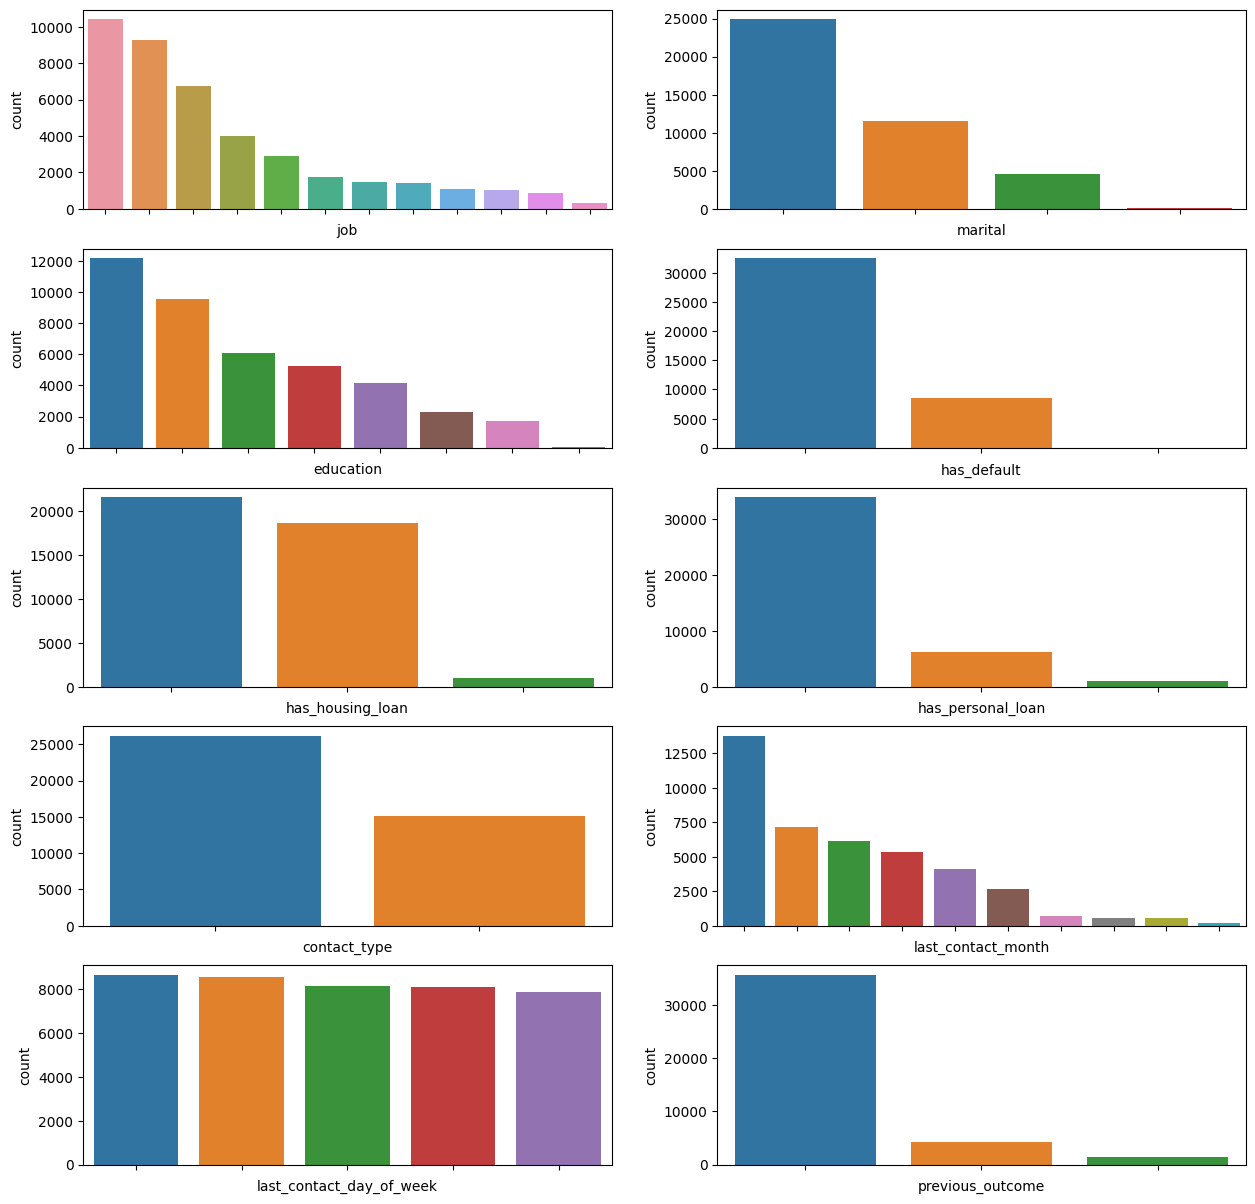

In [18]:
categorical_columns = list(df.select_dtypes('object').columns)

idx = 0
grid_height = 5
grid_width = 2
number_of_plots = 10
data = df

# # Visualize the categorical columns. But I disable this to save time. I use prebuilt visualization instead.

# fig, axes = plt.subplots(grid_height, grid_width, figsize=(15, 15))
# for i in list(range(grid_height)):
#   for j in list(range(grid_width)):
#     if idx < number_of_plots:
#       ax = sns.countplot(ax=axes[i, j], data = data, x=categorical_columns[idx], lw=0, order=data[categorical_columns[idx]].value_counts().index)
#       ax.set(xticklabels=[])
#       idx += 1


image_path = '/content/drive/MyDrive/Virtual Experience/pwc_1_categorical_viz.png'
Image(image_path)


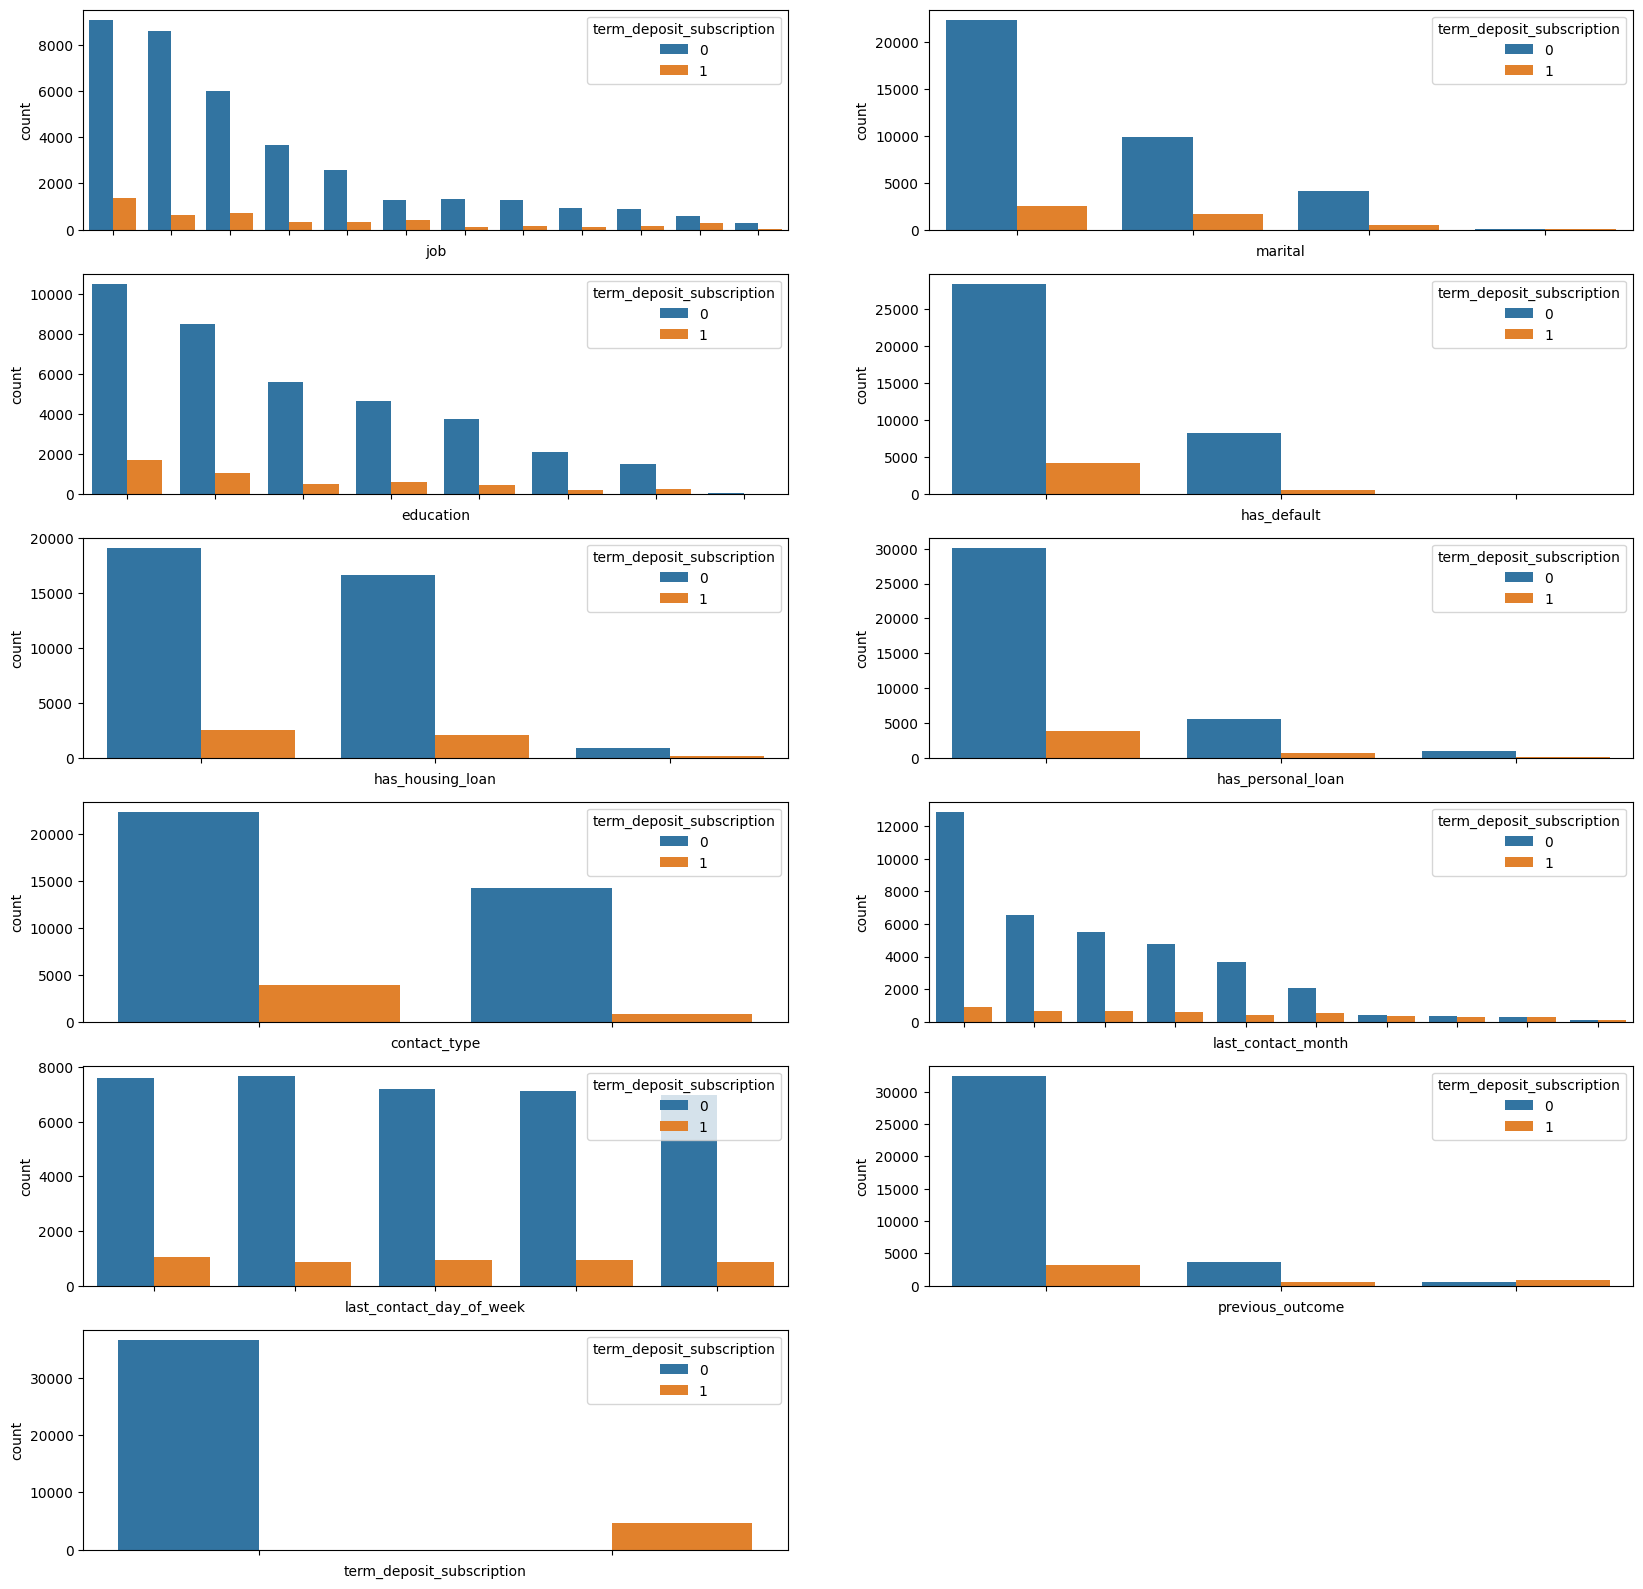

In [19]:
categorical_columns = list(df.select_dtypes('object').columns)
categorical_columns.append('term_deposit_subscription')

idx = 0
grid_height = 6
grid_width = 2
number_of_plots = 11
data = df

# # Visualize the categorical columns with hue. But I disable this to save time. I use prebuilt visualization instead.

# fig, axes = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# axes[-1, -1].axis('off')
# for i in list(range(grid_height)):
#   for j in list(range(grid_width)):
#     if idx < number_of_plots:
#       ax = sns.countplot(ax=axes[i, j], data = data, x=categorical_columns[idx], hue='term_deposit_subscription', lw=0, order=data[categorical_columns[idx]].value_counts().index)
#       ax.set(xticklabels=[])
#       idx += 1


image_path = '/content/drive/MyDrive/Virtual Experience/pwc_1_categorical_viz_hue.png'
Image(image_path)


Build correlation heat map.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

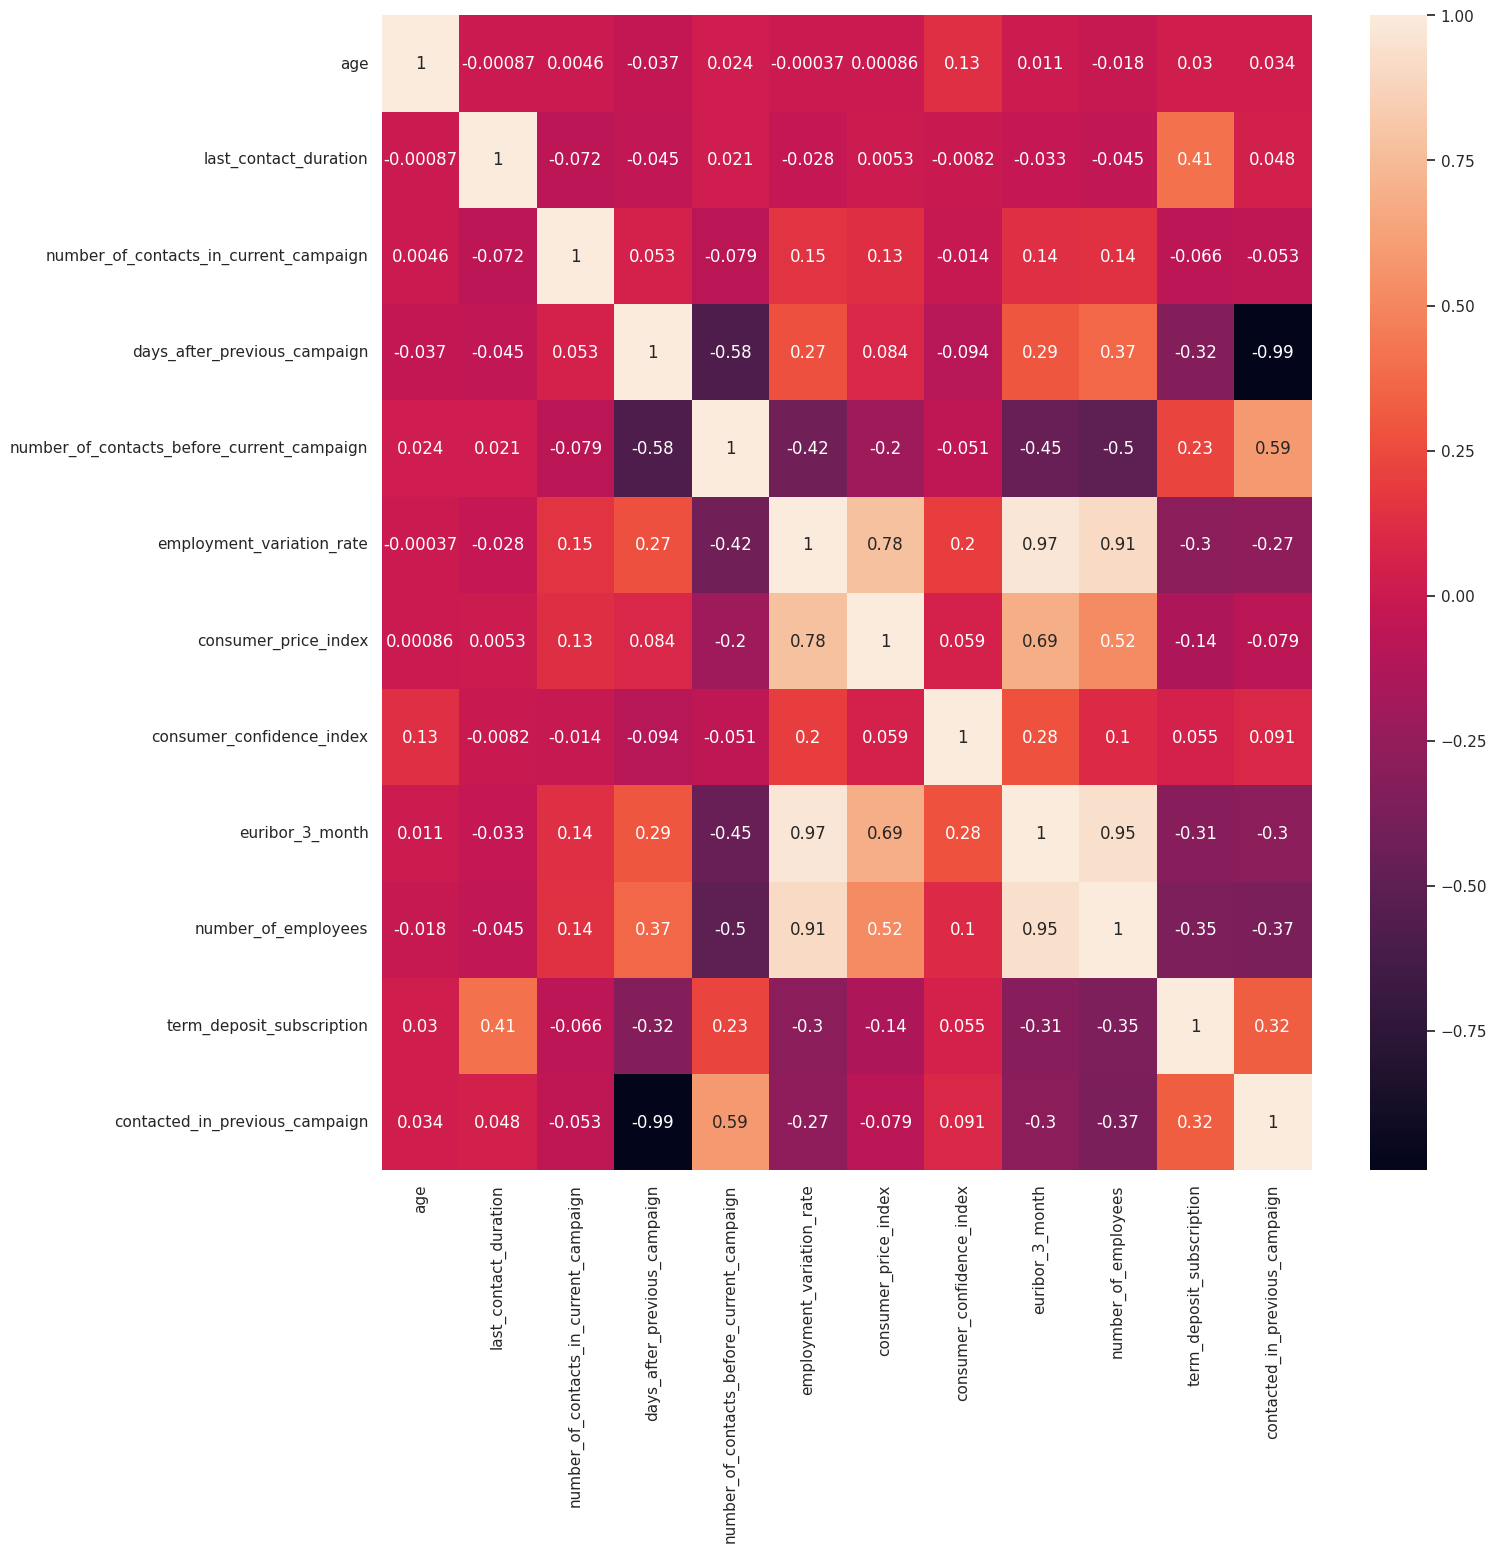

In [20]:
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(df.corr(), annot=True)

Drop the last contact duration column because it is a data leakage.

In [21]:
df = df.drop(['last_contact_duration'], axis=1)

Start building the models.

Copy the data frame before scaling.

In [22]:
df_unscaled = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         41188 non-null  int64  
 1   job                                         41188 non-null  object 
 2   marital                                     41188 non-null  object 
 3   education                                   41188 non-null  object 
 4   has_default                                 41188 non-null  object 
 5   has_housing_loan                            41188 non-null  object 
 6   has_personal_loan                           41188 non-null  object 
 7   contact_type                                41188 non-null  object 
 8   last_contact_month                          41188 non-null  object 
 9   last_contact_day_of_week                    41188 non-null  object 
 10  number_of_

Scale the numerical columns.

In [23]:
numerical_columns = list(df.select_dtypes('number').columns)
scaler = MinMaxScaler()
to_scale = numerical_columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df_scaled = df.copy()
df.head()


age        job  marital    education has_default has_housing_loan  \
0  0.481481  housemaid  married     basic.4y          no               no   
1  0.493827   services  married  high.school     unknown               no   
2  0.246914   services  married  high.school          no              yes   
3  0.283951     admin.  married     basic.6y          no               no   
4  0.481481   services  married  high.school          no               no   

  has_personal_loan contact_type last_contact_month last_contact_day_of_week  \
0                no    telephone                may                      mon   
1                no    telephone                may                      mon   
2                no    telephone                may                      mon   
3                no    telephone                may                      mon   
4               yes    telephone                may                      mon   

   ...  days_after_previous_campaign  \
0  ...                           1.0   
1  ...                           1.0   
2  ...                           1.0   
3  ...                           1.0   
4  ...                           1.0   

   number_of_contacts_before_current_campaign  previous_outcome  \
0                                         0.0       nonexistent   
1                                         0.0       nonexistent   
2                                         0.0       nonexistent   
3                                         0.0       nonexistent   
4                                         0.0       nonexistent   

  employment_variation_rate  consumer_price_index  consumer_confidence_index  \
0                    0.9375              0.698753                    0.60251   
1                    0.9375              0.698753                    0.60251   
2                    0.9375              0.698753                    0.60251   
3                    0.9375              0.698753                    0.60251   
4                    0.9375              0.698753                    0.60251   

   euribor_3_month  number_of_employees  term_deposit_subscription  \
0         0.957379             0.859735                        0.0   
1         0.957379             0.859735                        0.0   
2         0.957379             0.859735                        0.0   
3         0.957379             0.859735                        0.0   
4         0.957379             0.859735                        0.0   

   contacted_in_previous_campaign  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 21 columns]

Convert the categorical columns to category type.

In [24]:
df[categorical_columns] = df[categorical_columns].astype('category')
df[categorical_columns] = df[categorical_columns].apply(lambda x:x.cat.codes)
df.head()

age  job  marital  education  has_default  has_housing_loan  \
0  0.481481    3        1          0            0                 0   
1  0.493827    7        1          3            1                 0   
2  0.246914    7        1          3            0                 2   
3  0.283951    0        1          1            0                 0   
4  0.481481    7        1          3            0                 0   

   has_personal_loan  contact_type  last_contact_month  \
0                  0             1                   6   
1                  0             1                   6   
2                  0             1                   6   
3                  0             1                   6   
4                  2             1                   6   

   last_contact_day_of_week  ...  days_after_previous_campaign  \
0                         1  ...                           1.0   
1                         1  ...                           1.0   
2                         1  ...                           1.0   
3                         1  ...                           1.0   
4                         1  ...                           1.0   

   number_of_contacts_before_current_campaign  previous_outcome  \
0                                         0.0                 1   
1                                         0.0                 1   
2                                         0.0                 1   
3                                         0.0                 1   
4                                         0.0                 1   

   employment_variation_rate  consumer_price_index  consumer_confidence_index  \
0                     0.9375              0.698753                    0.60251   
1                     0.9375              0.698753                    0.60251   
2                     0.9375              0.698753                    0.60251   
3                     0.9375              0.698753                    0.60251   
4                     0.9375              0.698753                    0.60251   

   euribor_3_month  number_of_employees  term_deposit_subscription  \
0         0.957379             0.859735                          0   
1         0.957379             0.859735                          0   
2         0.957379             0.859735                          0   
3         0.957379             0.859735                          0   
4         0.957379             0.859735                          0   

   contacted_in_previous_campaign  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 21 columns]

Split the data for training and validation.

In [25]:
X = df.drop(['term_deposit_subscription'], axis=1)
y = df['term_deposit_subscription']

In [26]:
rf_model_file = 'pwc_1_rf_model.pkl'

def cv_hyperparameter_rf(X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

  if (os.path.isfile(rf_model_file)==False):

    rf = RandomForestClassifier()

    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
    cv = KFold(n_splits=5)

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)

    print('MEAN CROSS-VALIDATION SCORE: ', grid_search.best_score_)
    print('BEST HYPERPARAMETERS: ', grid_search.best_params_)

    n_estimators = grid_search.best_params_['n_estimators']
    max_depth = grid_search.best_params_['max_depth']

    rf_model = train_rf(X_train, X_test, y_train, y_test, n_estimators, max_depth)
  
  else:

    rf_model = pickle.load(open(rf_model_file, 'rb'))
    y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('AUC score:', roc_auc)
    print('Confusion Matrix:')

    cm = confusion_matrix(y_test, y_pred)
    sns.set(rc={'figure.figsize':(5, 5)})
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = rf_model.classes_)
    cm_plot.plot()
    plt.grid(False)
    plt.show()
  
  return rf_model

def train_rf(X_train, X_test, y_train, y_test, n_estimators, max_depth):
  rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)  
  
  rf_model = rf.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
  recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
  roc_auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1)
  print('AUC score:', roc_auc)
  print('Confusion Matrix:')

  cm = confusion_matrix(y_test, y_pred)
  sns.set(rc={'figure.figsize':(5, 5)})
  cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = rf_model.classes_)
  cm_plot.plot()
  plt.grid(False)
  plt.show()
  
  pickle.dump(rf_model, open(rf_model_file, 'wb'))

  return rf_model     

Accuracy: 0.9014323865015781
Precision: 0.697841726618705
Recall: 0.210412147505423
F1 Score: 0.32333333333333336
AUC score: 0.599465231762553
Confusion Matrix:


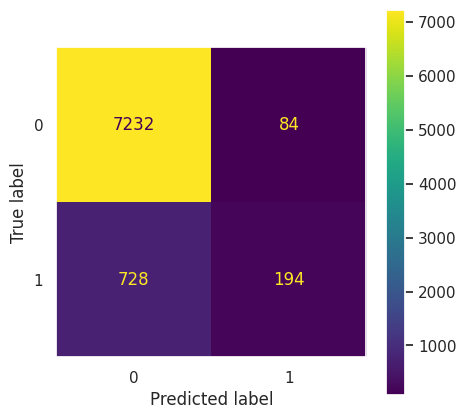

RandomForestClassifier(max_depth=7, n_estimators=200)

In [27]:
cv_hyperparameter_rf(X, y)

XGBoost model.

In [28]:
params = {'objective':'binary:logistic'}
xgb_model_file = 'pwc_1_xgb_model.pkl'

def xgb_prepare(df):
  X, y = df.drop('term_deposit_subscription', axis=1), df[['term_deposit_subscription']]
  y_encoded = OrdinalEncoder().fit_transform(y)
  categories = X.select_dtypes(exclude=np.number).columns.tolist()
  for column in categories:
    X[column] = X[column].astype('category')
  X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=12, stratify=y_encoded)
  return X_train, X_test, y_train, y_test, X, y_encoded

def xgb_cv(X_train, y_train, params):

  dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
  num_round = 1000
  results = xgb.cv(params, dtrain, num_round, nfold=5,
                   metrics={'error', 'auc'}, seed=12,
                   callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

  print('TEST ERROR MEAN', str(results['test-error-mean'].max()))
  print('TEST ERROR STD', str(results['test-error-std'].max()))
  print('TEST AUC MEAN', str(results['test-auc-mean'].max()))
  print('TEST AUC STD', str(results['test-auc-std'].max()))

def xgb_train(X_train, y_train, params):
  dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
  num_round = 5000
  evals = [(dtrain, 'train')]
  model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round, evals=evals, verbose_eval=50, early_stopping_rounds=50)

  pickle.dump(model, open(xgb_model_file, 'wb'))

In [29]:
X_train, X_test, y_train, y_test, X, y_encoded = xgb_prepare(df_scaled)

In [30]:
if (os.path.isfile(xgb_model_file)==False):
  xgb_cv(X_train, y_train, params)

In [31]:
if (os.path.isfile(xgb_model_file)==False):
  xgb_train(X_train, y_train, params)

In [32]:
def xgb_evaluate(xgb_model, X_test, y_test):

  dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

  # y_pred = xgb_model.predict(dtest)
  y_pred = np.rint(xgb_model.predict(dtest))

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
  recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
  roc_auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)

  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1)
  print('AUC score:', roc_auc)
  print('Confusion Matrix:')

  cm = confusion_matrix(y_test, y_pred)
  sns.set(rc={'figure.figsize':(5, 5)})
  cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
  cm_plot.plot()
  plt.grid(False)
  plt.show()

Accuracy: 0.8776402039329935
Precision: 0.4444444444444444
Recall: 0.3448275862068966
F1 Score: 0.3883495145631068
AUC score: 0.6450540119816972
Confusion Matrix:


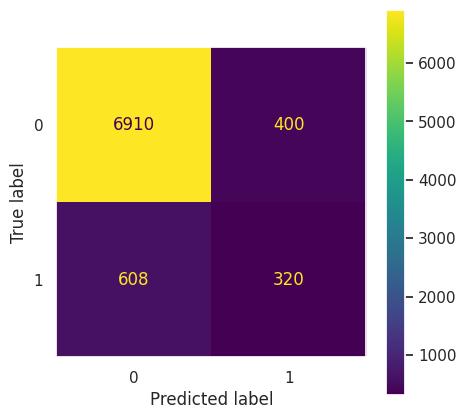

In [40]:
xgb_model = pickle.load(open(xgb_model_file, 'rb'))
xgb_evaluate(xgb_model, X_test, y_test)

Get global feature importances using SHAP library.

In [41]:
# explainer = shap.TreeExplainer(xgb_model)
# dmatrix = xgb.DMatrix(X, y_encoded, enable_categorical=True)
# shap_values = explainer.shap_values(dmatrix)

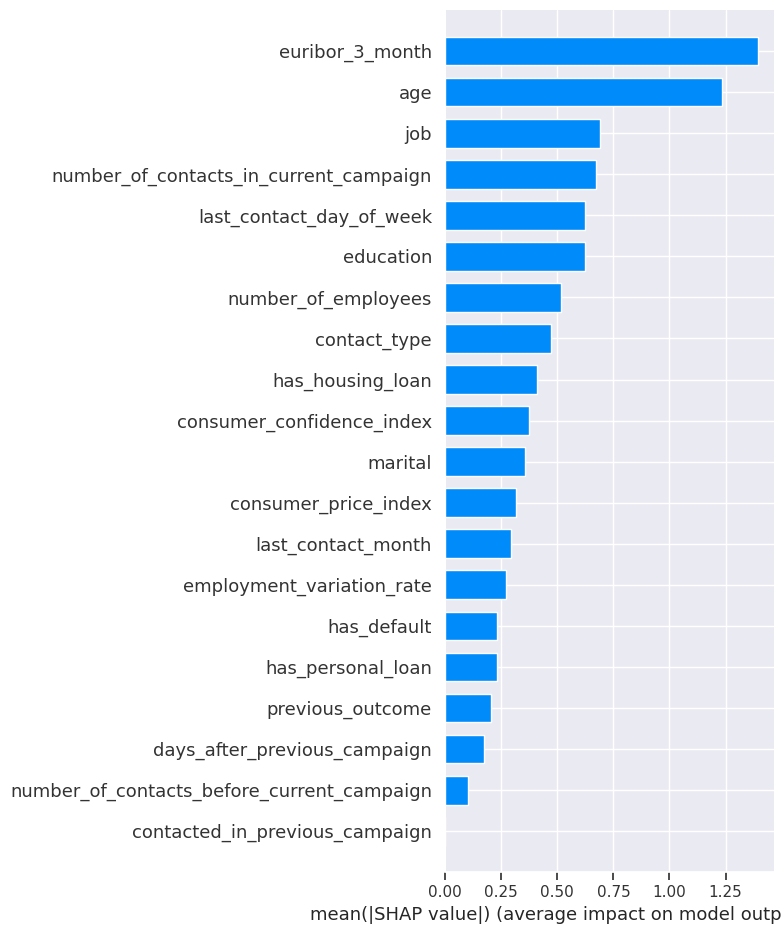

In [42]:
# sns.set(rc={'figure.figsize':(10, 10)})
# shap.summary_plot(shap_values, X, plot_type='bar')

image_path = '/content/drive/MyDrive/Virtual Experience/pwc_1_shap_summary_plot1.png'
Image(image_path)

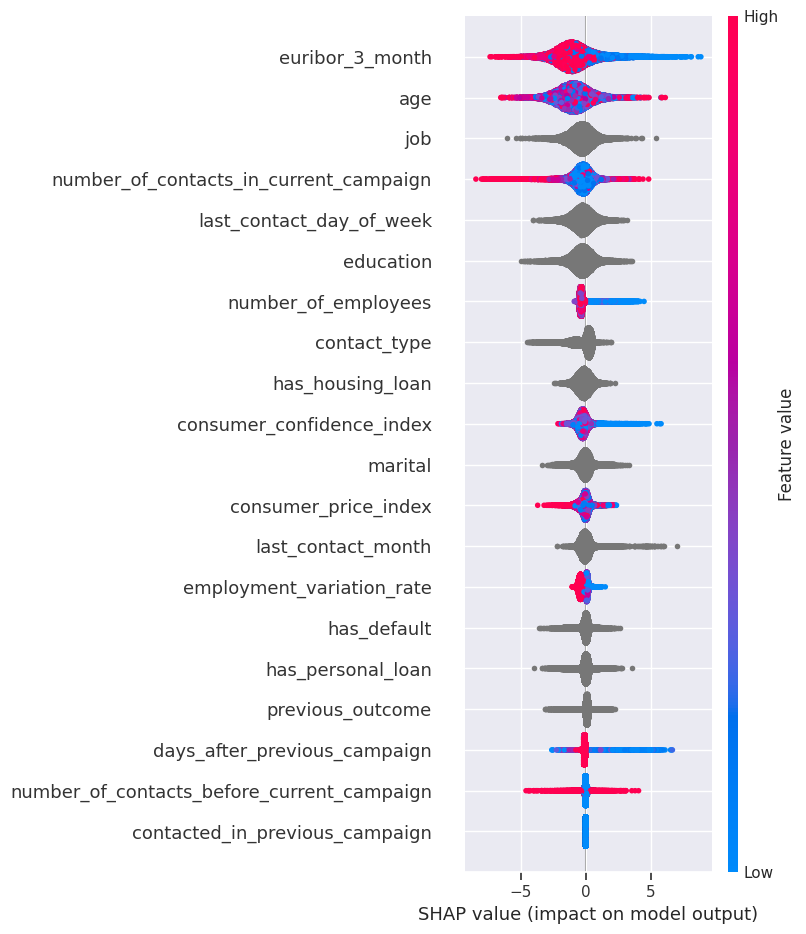

In [43]:
# shap.summary_plot(shap_values, X)

image_path = '/content/drive/MyDrive/Virtual Experience/pwc_1_shap_summary_plot2.png'
Image(image_path)

Get local explainer for rows number 4 an 20 using Lime.

In [46]:
label_binarizer = LabelBinarizer()

mapper = DataFrameMapper([
    (['age'], StandardScaler()),
    (['job'], LabelEncoder()),
    (['marital'], LabelEncoder()),
    (['education'], LabelEncoder()),
    (['has_default'], LabelEncoder()),
    (['has_housing_loan'], LabelEncoder()),
    (['has_personal_loan'], LabelEncoder()),
    (['contact_type'], LabelEncoder()),
    (['last_contact_month'], LabelEncoder()),
    (['last_contact_day_of_week'], LabelEncoder()),
    (['number_of_contacts_in_current_campaign'], StandardScaler()),
    (['days_after_previous_campaign'], StandardScaler()),
    (['number_of_contacts_before_current_campaign'], StandardScaler()),
    (['previous_outcome'], LabelEncoder()),
    (['employment_variation_rate'], StandardScaler()),
    (['consumer_price_index'], StandardScaler()),
    (['consumer_confidence_index'], StandardScaler()),
    (['euribor_3_month'], StandardScaler()),
    (['number_of_employees'], StandardScaler()),
    (['contacted_in_previous_campaign'], LabelEncoder()),
    (['term_deposit_subscription'], label_binarizer)
    ], df_out=True)

fitted_df = mapper.fit_transform(df_unscaled)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [47]:
feature_names = ['age', 'job', 'marital', 'education', 'has_default', 'has_housing_loan',
                 'has_personal_loan', 'contact_type', 'last_contact_month',
                 'last_contact_day_of_week', 'number_of_contacts_in_current_campaign',
                 'days_after_previous_campaign',
                 'number_of_contacts_before_current_campaign', 'previous_outcome',
                 'employment_variation_rate', 'consumer_price_index',
                 'consumer_confidence_index', 'euribor_3_month', 'number_of_employees',
                 'contacted_in_previous_campaign']
categorical_features_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 13]
categorical_names = {}
for feature in categorical_features_idx:
  le = LabelEncoder()
  le.fit(df_scaled.iloc[:, feature])
  categorical_names[feature] = le.classes_

explainer = lime.lime_tabular.LimeTabularExplainer(fitted_df.drop(columns=['term_deposit_subscription']).values,
                                                   feature_names=feature_names,
                                                   categorical_features=categorical_features_idx,
                                                   categorical_names=categorical_names,
                                                   class_names=label_binarizer.classes_,
                                                   kernel_width=3, verbose=False)

In [94]:
def wrapped_predict(data_x):

  dummy_y = np.array([1 for _ in range(data_x.shape[0])])
  tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=feature_names)
  tmp_out = xgb_model.predict(tmp_data)
  out = np.zeros((data_x.shape[0], 2))
  out[:, 0] = 1 - tmp_out
  out[:, 1] = tmp_out
  return out

In [112]:
i = 4
features_data = fitted_df.drop(columns=['term_deposit_subscription'])
input = np.array(fitted_df.loc[i, features_data.columns].values)
exp = explainer.explain_instance(input, wrapped_predict, num_features=10)
exp.show_in_notebook(show_table=True)

In [114]:
fitted_df.iloc[[4]].T

4
age                                         1.533034
job                                         7.000000
marital                                     1.000000
education                                   3.000000
has_default                                 0.000000
has_housing_loan                            0.000000
has_personal_loan                           2.000000
contact_type                                1.000000
last_contact_month                          6.000000
last_contact_day_of_week                    1.000000
number_of_contacts_in_current_campaign     -0.565922
days_after_previous_campaign                0.193549
number_of_contacts_before_current_campaign -0.349494
previous_outcome                            1.000000
employment_variation_rate                   0.648092
consumer_price_index                        0.722722
consumer_confidence_index                   0.886447
euribor_3_month                             0.712460
number_of_employees                         0.331680
contacted_in_previous_campaign              0.000000
term_deposit_subscription                   0.000000

In [113]:
i = 20
# features_data = fitted_df
features_data = fitted_df.drop(columns=['term_deposit_subscription'])
input = np.array(fitted_df.loc[i, features_data.columns].values)
exp = explainer.explain_instance(input, wrapped_predict, num_features=10)
exp.show_in_notebook(show_table=True)

In [110]:
fitted_df.iloc[[20]].T

20
age                                         -0.961898
job                                         10.000000
marital                                      1.000000
education                                    3.000000
has_default                                  0.000000
has_housing_loan                             0.000000
has_personal_loan                            0.000000
contact_type                                 1.000000
last_contact_month                           6.000000
last_contact_day_of_week                     1.000000
number_of_contacts_in_current_campaign      -0.565922
days_after_previous_campaign                 0.193549
number_of_contacts_before_current_campaign  -0.349494
previous_outcome                             1.000000
employment_variation_rate                    0.648092
consumer_price_index                         0.722722
consumer_confidence_index                    0.886447
euribor_3_month                              0.712460
number_of_employees                          0.331680
contacted_in_previous_campaign               0.000000
term_deposit_subscription                    0.000000